# House Prices
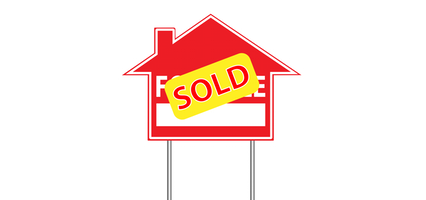

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, validation_curve, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, roc_auc_score, make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import time

import warnings
warnings.filterwarnings('ignore')

In [3]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

house-prices-advanced-regression-techniques



In [4]:
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
description = pd.read_table("../input/house-prices-advanced-regression-techniques/data_description.txt", delim_whitespace=True, error_bad_lines=False)

b'Skipping line 56: expected 10 fields, saw 12\nSkipping line 121: expected 10 fields, saw 11\nSkipping line 180: expected 10 fields, saw 12\nSkipping line 260: expected 10 fields, saw 11\nSkipping line 298: expected 10 fields, saw 12\nSkipping line 356: expected 10 fields, saw 11\nSkipping line 358: expected 10 fields, saw 12\nSkipping line 408: expected 10 fields, saw 14\nSkipping line 418: expected 10 fields, saw 12\nSkipping line 521: expected 10 fields, saw 15\nSkipping line 523: expected 10 fields, saw 12\n'


In [5]:
description

,MSSubClass:,Identifies,the,type,of,dwelling,involved,in,the.1,sale.
0,20,1-STORY,1946,&,NEWER,ALL,STYLES,NaN,NaN,NaN
1,30,1-STORY,1945,&,OLDER,NaN,NaN,NaN,NaN,NaN
2,40,1-STORY,W/FINISHED,ATTIC,ALL,AGES,NaN,NaN,NaN,NaN
3,45,1-1/2,STORY,-,UNFINISHED,ALL,AGES,NaN,NaN,NaN
4,50,1-1/2,STORY,FINISHED,ALL,AGES,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
382,SaleCondition:,Condition,of,sale,NaN,NaN,NaN,NaN,NaN,NaN
383,Normal,Normal,Sale,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384,Abnorml,Abnormal,Sale,-,"trade,","foreclosure,",short,sale,NaN,NaN
385,AdjLand,Adjoining,Land,Purchase,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MSSubClass:  373 non-null    object
 1   Identifies   387 non-null    object
 2   the          279 non-null    object
 3   type         168 non-null    object
 4   of           116 non-null    object
 5   dwelling     84 non-null     object
 6   involved     61 non-null     object
 7   in           34 non-null     object
 8   the.1        15 non-null     object
 9   sale.        5 non-null      object
dtypes: object(10)
memory usage: 30.4+ KB


In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Goal: predict sales prices by given features

## Data fields

* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

In [9]:
orig_train = train.copy()

In [10]:
orig_test = test.copy()

In [11]:
orig_train.tail(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


#just for convinience
orig_cols = list(train.columns)
new_cols = []
for col in orig_cols:
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
train.columns = new_cols

orig_cols1 = list(test.columns)
new_cols1 = []
for colm in orig_cols1:
    new_cols1.append(colm.strip().replace('  ', ' ').replace(' ', '_').lower())
test.columns = new_cols1

In [12]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
import missingno as msno

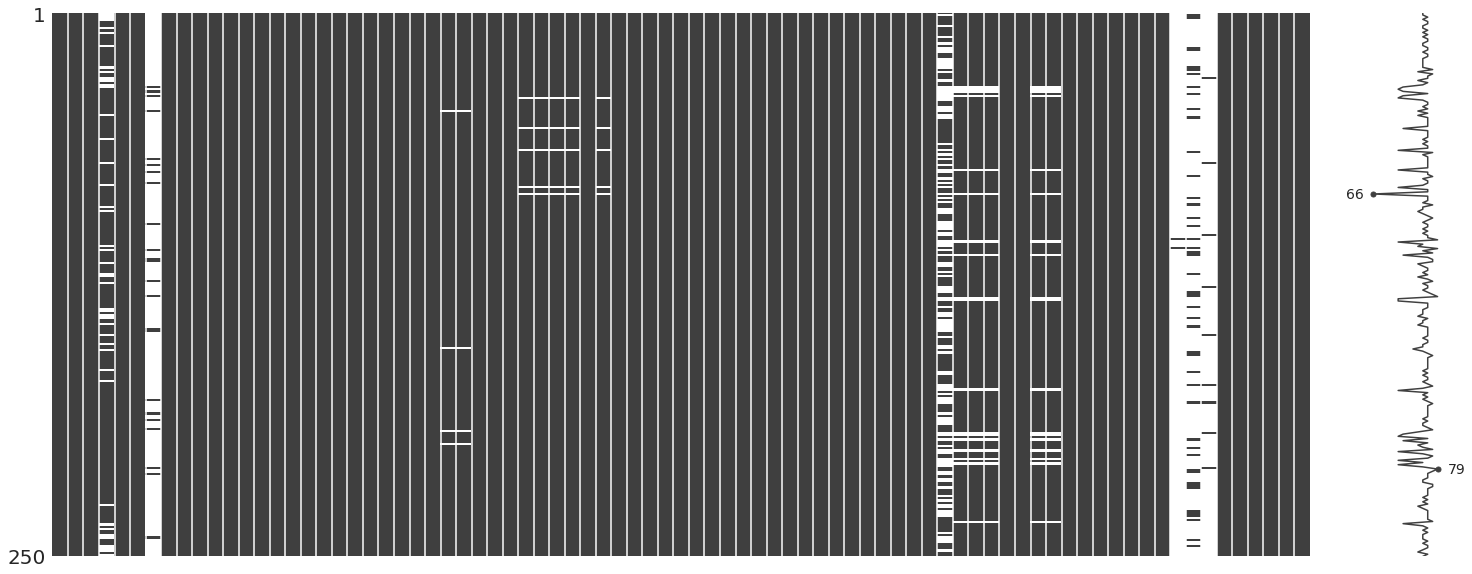

In [14]:
#Visualising missing values for a sample of 250
msno.matrix(train.sample(250))

In [15]:
train.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


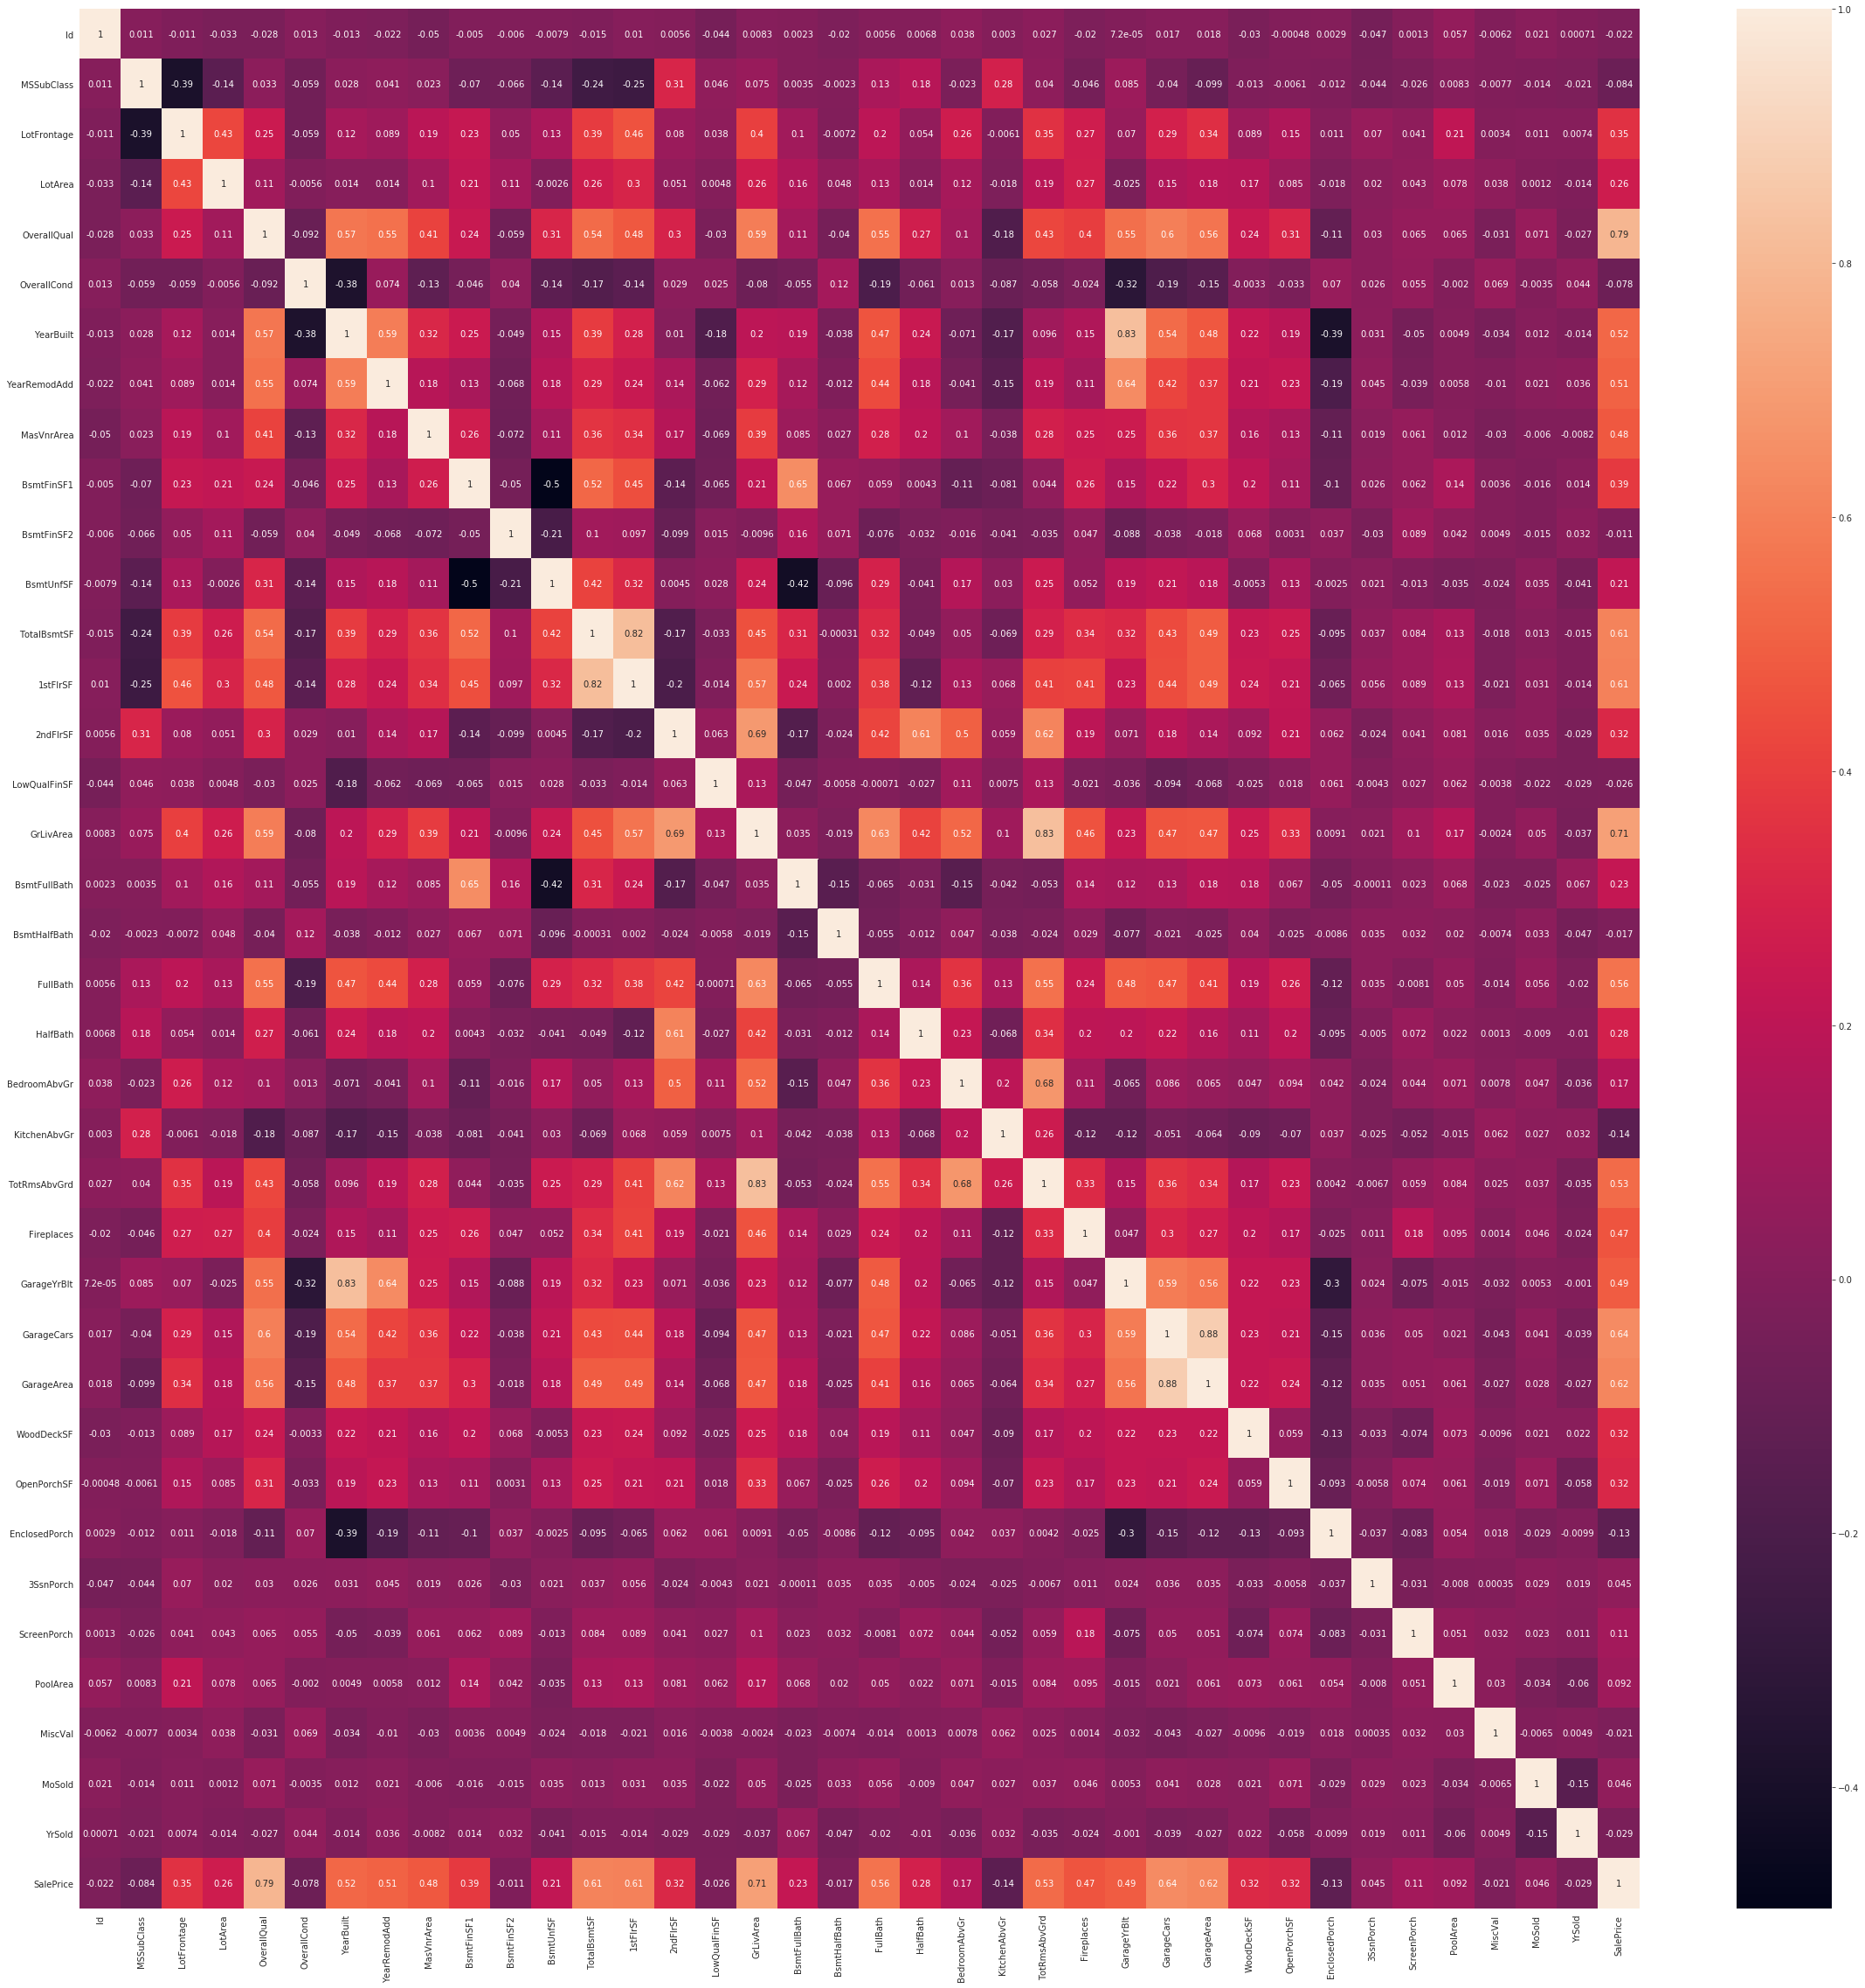

In [16]:
f, ax = plt.subplots(1, figsize=(40,40))
sns.heatmap(train.corr(), annot=True, ax=ax)

### Dendrogram
##### The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:

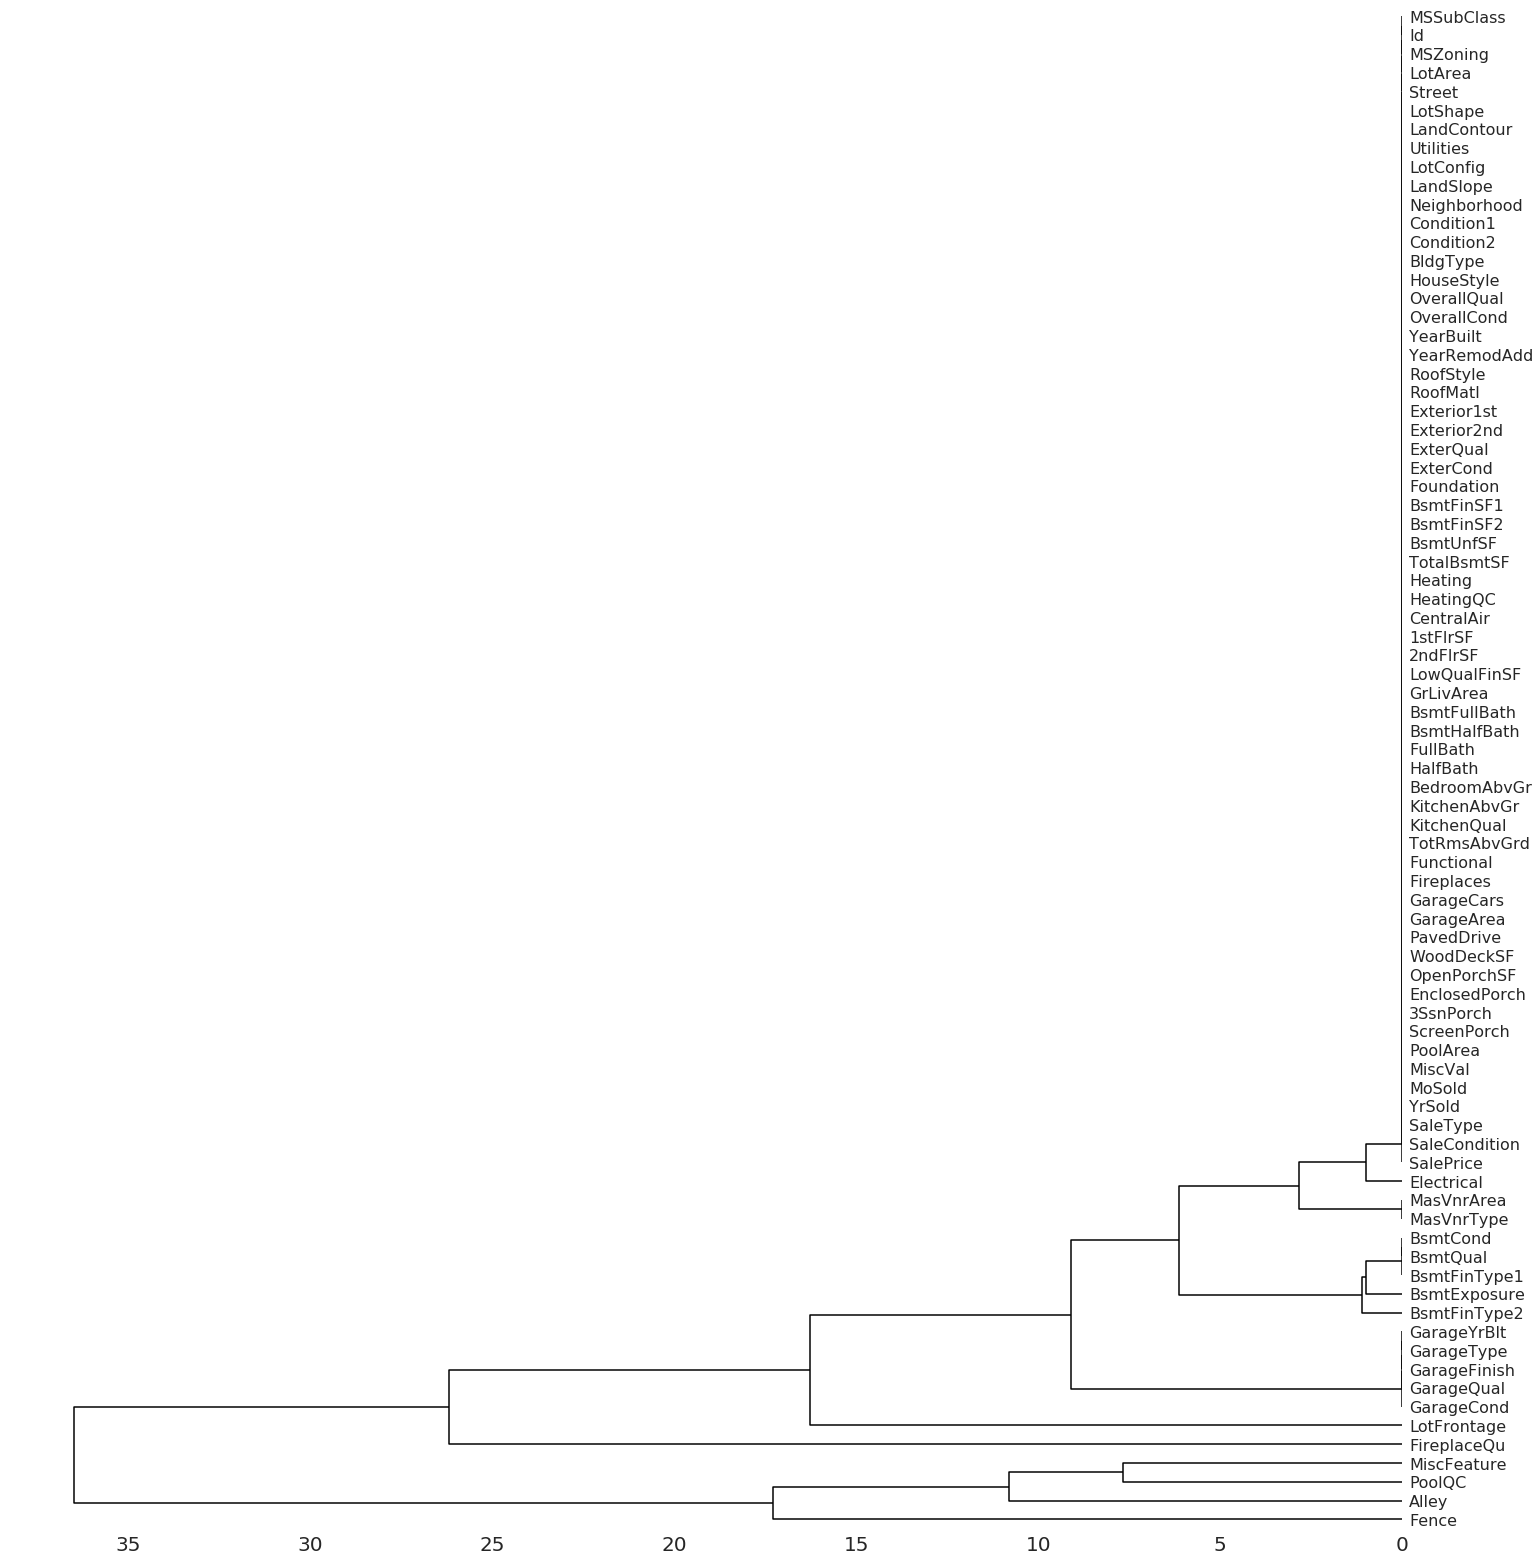

In [17]:
msno.dendrogram(train)

In [18]:
#looking for missing values, data types
#cool function

def data_info(dataframe):
    print('MISSING VALUES\n', dataframe.isnull().sum())
    print('\n DATA TYPES \n', dataframe.dtypes)
    print('\n DATA SHAPE \n', dataframe.shape)
    for item in dataframe:
        print('\n UNIQUE VALUE TOTALS \n',item)
        print(dataframe[item].nunique())
        print(dataframe[item].value_counts())
        
        
data_info(train)

MISSING VALUES
 Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

 DATA TYPES 
 Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

 DATA SHAPE 
 (1460, 81)

 UNIQUE VALUE TOTALS 
 Id
1460
1460    1
479     1
481     1
482     1
483     1
       ..
976     1
977     1
978     1
979     1
1       1
Name: Id, Length: 1460, dtype: int64

 UNIQUE VALUE TOTALS 
 MSSubClass
15
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [21]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB


In [22]:
for col in train.select_dtypes(include=['float64']).columns:
    train[col] = train[col].astype('float32')
    
for col in train.select_dtypes(include=['int64']).columns:
    train[col] = train[col].astype('int32')
    
for col in test.select_dtypes(include=['float64']).columns:
    test[col] = test[col].astype('float32')
    
for col in test.select_dtypes(include=['int64']).columns:
    test[col] = test[col].astype('int32')
    
for col in submission.select_dtypes(include=['float64']).columns:
    submission[col] = submission[col].astype('float32')
    
for col in submission.select_dtypes(include=['int64']).columns:
    submission[col] = submission[col].astype('int32')

In [23]:
train.info()
test.info()
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int32  
 1   MSSubClass     1460 non-null   int32  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float32
 4   LotArea        1460 non-null   int32  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int32  
 18  OverallC

In [24]:
columns = train.columns
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_data = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_data.sort_values('percent_missing')

,column_name,percent_missing
Id,Id,0.000000
TotalBsmtSF,TotalBsmtSF,0.000000
Heating,Heating,0.000000
SaleCondition,SaleCondition,0.000000
CentralAir,CentralAir,0.000000
...,...,...
FireplaceQu,FireplaceQu,47.260274
Fence,Fence,80.753425
Alley,Alley,93.767123
MiscFeature,MiscFeature,96.301370


In [25]:
columnss = test.columns
percent_missingg = test.isnull().sum() * 100 / len(test)
missing_value_dataa = pd.DataFrame({'column_name': columnss,
                                 'percent_missing': percent_missingg})
missing_value_dataa.sort_values('percent_missing')

,column_name,percent_missing
Id,Id,0.000000
Foundation,Foundation,0.000000
HeatingQC,HeatingQC,0.000000
CentralAir,CentralAir,0.000000
Electrical,Electrical,0.000000
...,...,...
FireplaceQu,FireplaceQu,50.034270
Fence,Fence,80.123372
Alley,Alley,92.666210
MiscFeature,MiscFeature,96.504455


In [26]:
def nulls_breakdown(data):
    data_cols = list(data.columns)
    cols_total_count = len(list(data.columns))
    cols_count = 0
    for loc, col in enumerate(data_cols):
        null_count = data[col].isnull().sum()
        total_count = data[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(cols_total_count, cols_count, cols_percent_null))

###### So, the main parameter, to which we pay attention is a "saleprice". Let's look on graphics.

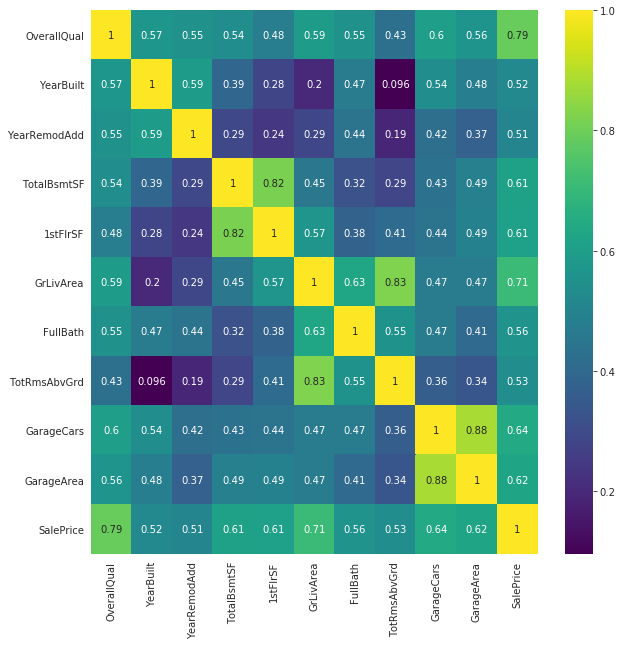

In [27]:
# most correlated features with Saleprice
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat['SalePrice'])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap='viridis')

###### Sooo, what we see... Some high correlations between depending variables like (sorry for lowercase, now it's harder to read)
* Garage area (Size of garage in square feet) and Garage Cars (Size of garage in car capacity)
* TotalBsmtSF (Total square feet of basement area) and 1stFlrSF (First Floor square feet)
* GrLivArea (Above grade/ground living area square feet) and TotRmsAbvGrd (Total rooms above grade without bathrooms)

###### Other features that highly correlated with SalePrice:
* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated
* 'GarageCars' and 'GarageArea' are strongly correlated variables. It is because the number of cars that fit into the garage is a consequence of the garage area. Therefore, we just need one of them (take 'GarageArea')
* 'TotalBsmtSF' and '1stFloor' the same story In this case let's keep 'TotalBsmtSF'
* 'TotRmsAbvGrd' and 'GrLivArea', also
* 'YearBuilt' it appears like is slightly correlated (TSA,noooooo).

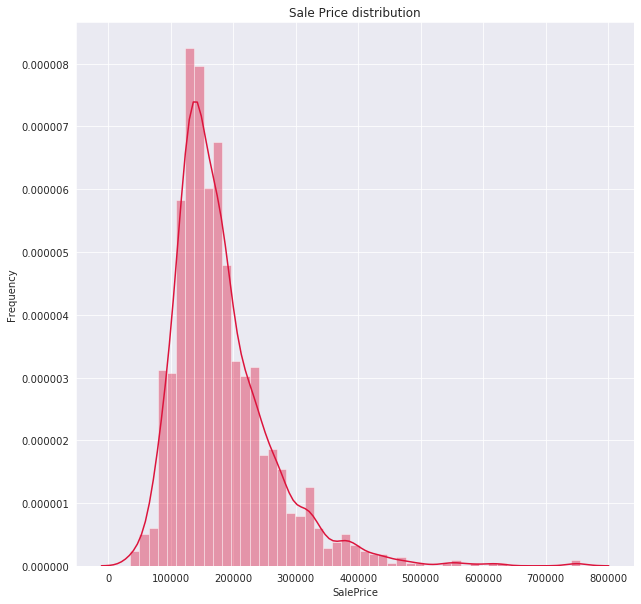

In [28]:
f, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train['SalePrice'], color='crimson');
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='Sale Price distribution')
plt.show()

In [29]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


###### It shows us:
* **Deviate** from the normal distribution.
* Have appreciable **positive** skewness.
* Show peakedness.
* Skewness 1.88
* Kurtosis (tails of a distribution differ from the tails of a normal distribution) 6.54

From heatmap there're some numerical columns that correlate with SalePrice: 'OverallQual', 'GrLivArea' and etc.

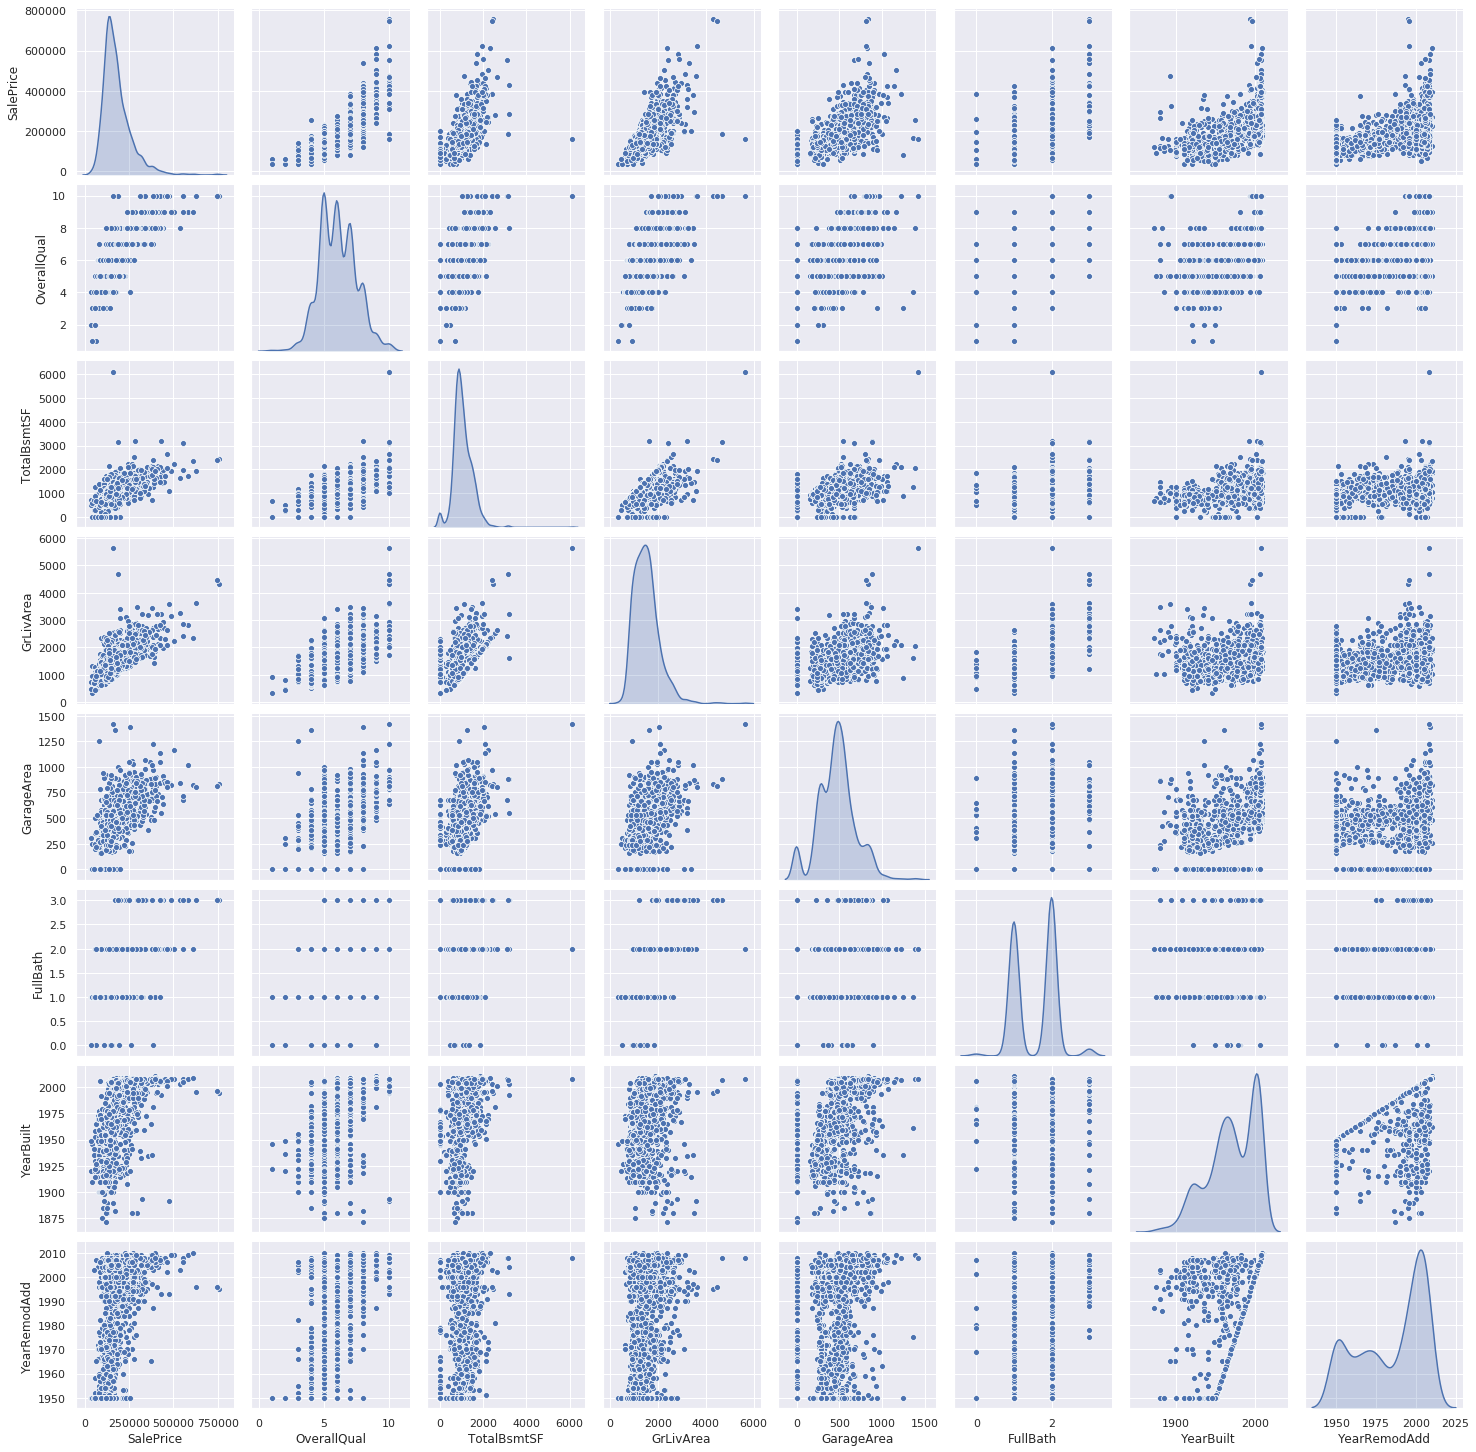

In [30]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'FullBath', 'YearBuilt','YearRemodAdd']
sns.pairplot(train[cols], size = 2.5,kind ='scatter',diag_kind='kde')
plt.show();

I'm gonna use scatter plots

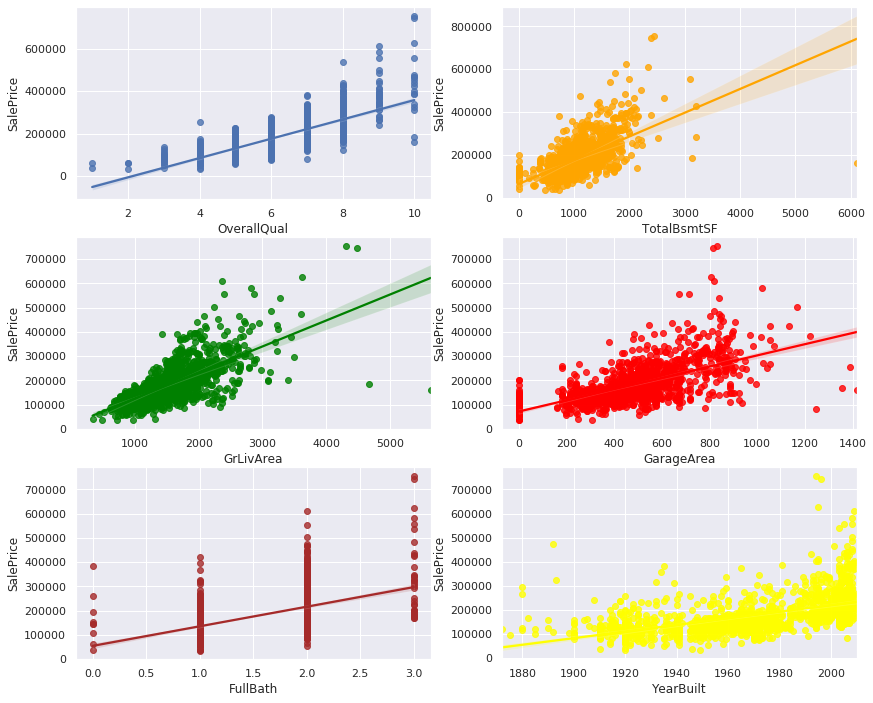

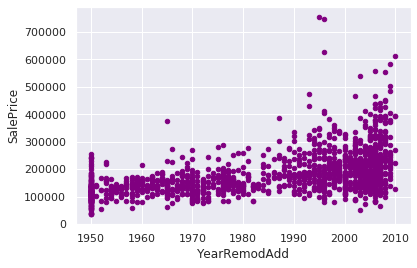

In [31]:
fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(14,12))

OverallQual_scatter_plot = pd.concat([train['SalePrice'],train['OverallQual']],axis = 1)
sns.regplot(x='OverallQual',y = 'SalePrice',data = OverallQual_scatter_plot,scatter= True, fit_reg=True, ax=ax1)

TotalBsmtSF_scatter_plot = pd.concat([train['SalePrice'],train['TotalBsmtSF']],axis = 1)
sns.regplot(x='TotalBsmtSF',y = 'SalePrice',data = TotalBsmtSF_scatter_plot,scatter= True, fit_reg=True, ax=ax2, color='orange')

GrLivArea_scatter_plot = pd.concat([train['SalePrice'],train['GrLivArea']],axis = 1)
sns.regplot(x='GrLivArea',y = 'SalePrice',data = GrLivArea_scatter_plot,scatter= True, fit_reg=True, ax=ax3, color='green')

GarageArea_scatter_plot = pd.concat([train['SalePrice'],train['GarageArea']],axis = 1)
sns.regplot(x='GarageArea',y = 'SalePrice',data = GarageArea_scatter_plot,scatter= True, fit_reg=True, ax=ax4, color='red')

FullBath_scatter_plot = pd.concat([train['SalePrice'],train['FullBath']],axis = 1)
sns.regplot(x='FullBath',y = 'SalePrice',data = FullBath_scatter_plot,scatter= True, fit_reg=True, ax=ax5, color='brown')

YearBuilt_scatter_plot = pd.concat([train['SalePrice'],train['YearBuilt']],axis = 1)
sns.regplot(x='YearBuilt',y = 'SalePrice',data = YearBuilt_scatter_plot,scatter= True, fit_reg=True, ax=ax6, color='yellow')

YearRemodAdd_scatter_plot = pd.concat([train['SalePrice'],train['YearRemodAdd']],axis = 1)
YearRemodAdd_scatter_plot.plot.scatter('YearRemodAdd','SalePrice',  color='purple')

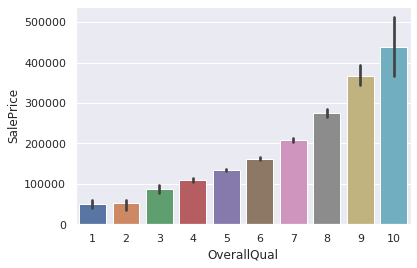

In [32]:
sns.barplot(orig_train.OverallQual,orig_train.SalePrice)

How each feature in OverallQual is correlated with SalePrice

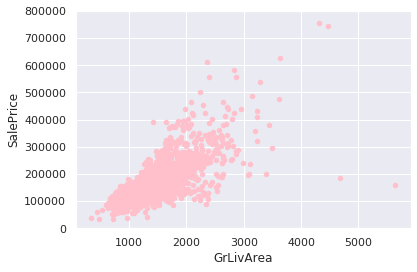

In [33]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000),color='pink');

Typical Linear Relationship 

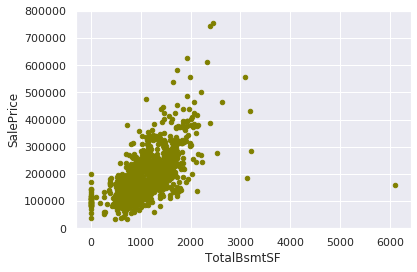

In [34]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), color='olive');

A lot of zero values and Exponential (?)

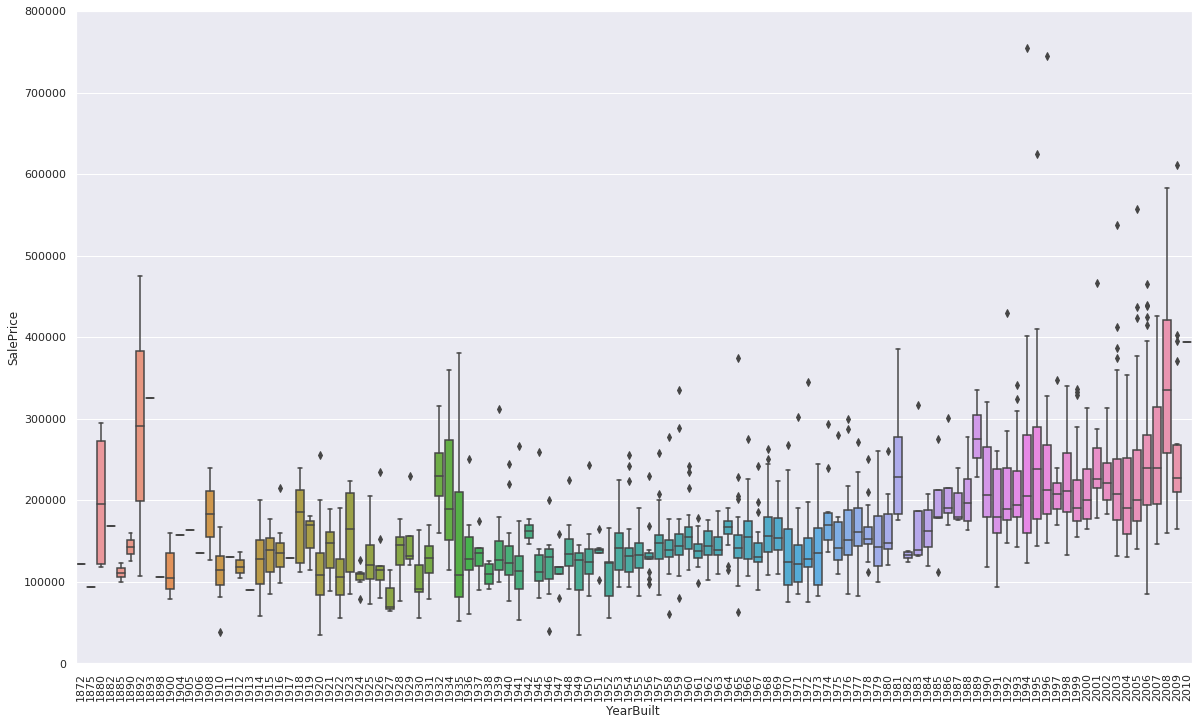

In [35]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x='YearBuilt', y="SalePrice", data=train)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

(1872 - 2010) New houses has higher price

###### Joint Plot uses Scatter Plot and Histogram. Joint Plot can also display data using Kernel Density Estimate (KDE) and Hexagons. We can also draw a Regression Line in Scatter Plot.

<Figure size 1008x720 with 0 Axes>

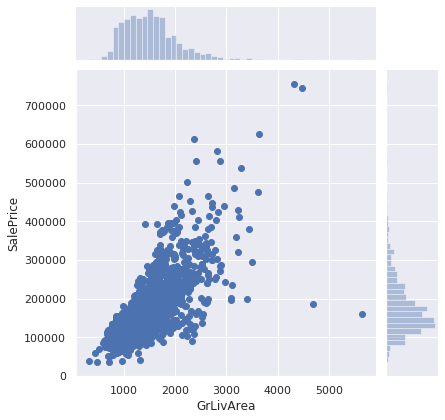

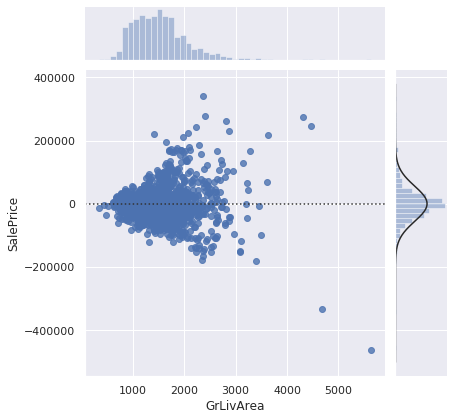

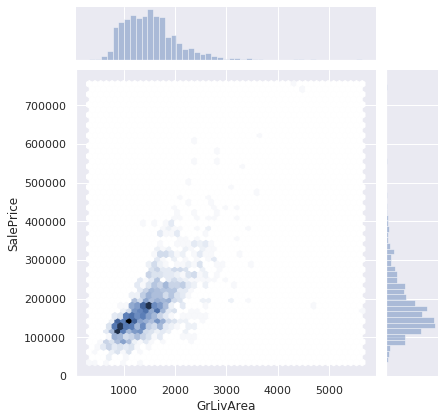

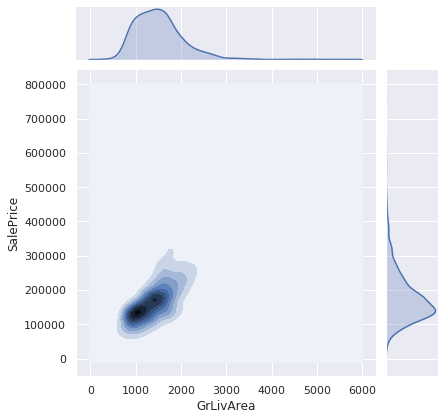

In [36]:
plt.figure(figsize=(14,10))
sns.set_style("darkgrid")

sns.jointplot(x=train["GrLivArea"], y=train['SalePrice'], kind='scatter')

sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='resid')

sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='hex')

sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='kde')

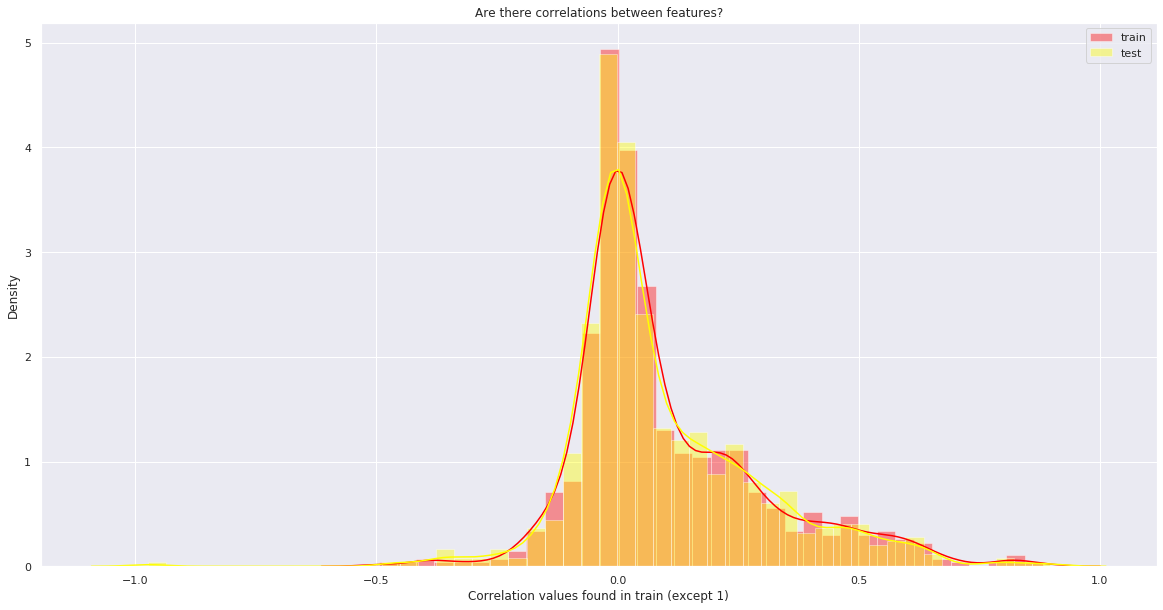

In [37]:
train_correlations = train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,10))
sns.distplot(train_correlations, color='Red', label='train')
sns.distplot(test_correlations, color='Yellow', label='test')
plt.xlabel('Correlation values found in train (except 1)')
plt.ylabel('Density')
plt.title('Are there correlations between features?'); 
plt.legend();

In [38]:
from scipy.stats import skew, norm
from scipy import stats


 mu = 180921.20 and sigma = 79415.29



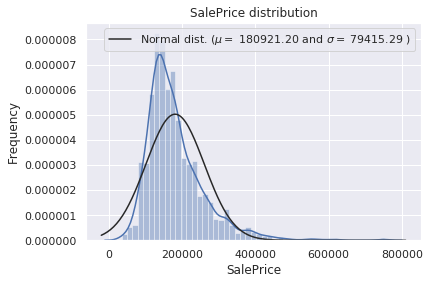

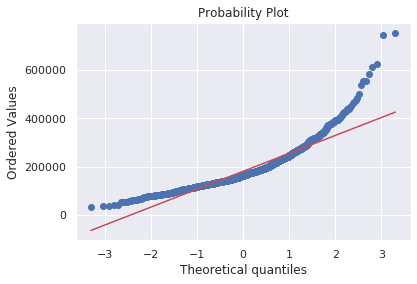

In [39]:
sns.distplot(orig_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(orig_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(orig_train['SalePrice'], plot=plt)
plt.show()

In [40]:
# log(1+x) transform for fixing skew
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



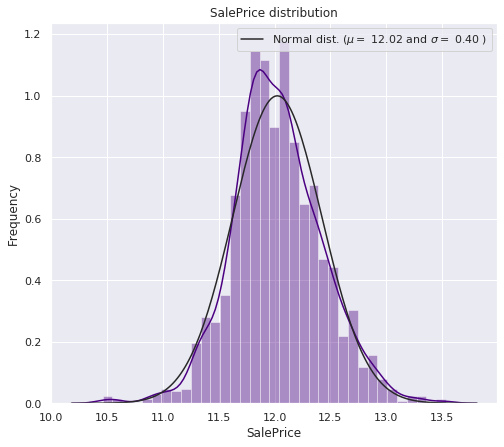

In [41]:
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color='indigo');

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')

plt.show()

The SalePrice is now normally distributed

In [42]:
#Copying data before removing 
train_v1 = train.copy()
test_v1 = test.copy()

In [43]:
train_v1.shape, test_v1.shape

((1460, 81), (1459, 80))

In [44]:
uniqId = len(set(train.Id))
uniqIdd = len(set(test.Id))
totId = train.shape[0]
totIdd = test.shape[0]
dupId = totId - uniqId
dupIdd = totIdd - uniqIdd
print('Duplicated IDs in train: ',dupId)
print('Duplicated IDs in test: ',dupIdd)

Duplicated IDs in train:  0
Duplicated IDs in test:  0


In [45]:
nulls_breakdown(train)

[iloc = 3] LotFrontage has 259 null values: 17.74% null
[iloc = 6] Alley has 1369 null values: 93.77% null
[iloc = 25] MasVnrType has 8 null values: 0.55% null
[iloc = 26] MasVnrArea has 8 null values: 0.55% null
[iloc = 30] BsmtQual has 37 null values: 2.53% null
[iloc = 31] BsmtCond has 37 null values: 2.53% null
[iloc = 32] BsmtExposure has 38 null values: 2.6% null
[iloc = 33] BsmtFinType1 has 37 null values: 2.53% null
[iloc = 35] BsmtFinType2 has 38 null values: 2.6% null
[iloc = 42] Electrical has 1 null values: 0.07% null
[iloc = 57] FireplaceQu has 690 null values: 47.26% null
[iloc = 58] GarageType has 81 null values: 5.55% null
[iloc = 59] GarageYrBlt has 81 null values: 5.55% null
[iloc = 60] GarageFinish has 81 null values: 5.55% null
[iloc = 63] GarageQual has 81 null values: 5.55% null
[iloc = 64] GarageCond has 81 null values: 5.55% null
[iloc = 72] PoolQC has 1453 null values: 99.52% null
[iloc = 73] Fence has 1179 null values: 80.75% null
[iloc = 74] MiscFeature has 1

In [46]:
nulls_breakdown(test)

[iloc = 2] MSZoning has 4 null values: 0.27% null
[iloc = 3] LotFrontage has 227 null values: 15.56% null
[iloc = 6] Alley has 1352 null values: 92.67% null
[iloc = 9] Utilities has 2 null values: 0.14% null
[iloc = 23] Exterior1st has 1 null values: 0.07% null
[iloc = 24] Exterior2nd has 1 null values: 0.07% null
[iloc = 25] MasVnrType has 16 null values: 1.1% null
[iloc = 26] MasVnrArea has 15 null values: 1.03% null
[iloc = 30] BsmtQual has 44 null values: 3.02% null
[iloc = 31] BsmtCond has 45 null values: 3.08% null
[iloc = 32] BsmtExposure has 44 null values: 3.02% null
[iloc = 33] BsmtFinType1 has 42 null values: 2.88% null
[iloc = 34] BsmtFinSF1 has 1 null values: 0.07% null
[iloc = 35] BsmtFinType2 has 42 null values: 2.88% null
[iloc = 36] BsmtFinSF2 has 1 null values: 0.07% null
[iloc = 37] BsmtUnfSF has 1 null values: 0.07% null
[iloc = 38] TotalBsmtSF has 1 null values: 0.07% null
[iloc = 47] BsmtFullBath has 2 null values: 0.14% null
[iloc = 48] BsmtHalfBath has 2 null va

As we can see some of columns have about 50-100 % of missing values.

In [47]:
train_nas = train.isnull().sum()
train_nas = train_nas[train_nas>0]
train_nas.sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [48]:
test_nas = test.isnull().sum()
test_nas = test_nas[test_nas>0]
test_nas.sort_values(ascending = False)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

In [49]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
#see at the heatmap also

Find most important features relative to target
SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    

In [50]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['YrSold'] = train['YrSold'].astype(str)
test['YrSold'] = test['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

In [51]:
#drop id col
train.drop(['Id'],axis =1,inplace=True)

In [52]:
#numerical features and categorical features
categorical_features = train.select_dtypes(include=['object']).columns
print('Categorical Features: ', categorical_features)
print('\n')
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]
print('\n')
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

Categorical Features:  Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')


Numerical features : 33
Categorical features : 46


NAs for numerical features in train : 348


1) Choose median() for filling

In [53]:
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
print('\n')
nulls_breakdown(train_num)

Remaining NAs for numerical features in train : 0


Out of 33 total columns, 0 contain null values; 0.0% columns contain null values.


2) handle filling (found cool func)

In [54]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

In [55]:
train_v2 = handle_missing(train)
test_v2 = handle_missing(test)

In [56]:
print('Train, Test')
nulls_breakdown(train)
nulls_breakdown(test)
print('Train_2, Test_2')
nulls_breakdown(train_v2)
nulls_breakdown(test_v2)

Train, Test
Out of 80 total columns, 0 contain null values; 0.0% columns contain null values.
Out of 80 total columns, 0 contain null values; 0.0% columns contain null values.
Train_2, Test_2
Out of 80 total columns, 0 contain null values; 0.0% columns contain null values.
Out of 80 total columns, 0 contain null values; 0.0% columns contain null values.


In [57]:
print('Train, Test: ', train.shape, test.shape)
print('Train_v2, Test_v2: ', train_v2.shape, test_v2.shape)

Train, Test:  (1460, 80) (1459, 80)
Train_v2, Test_v2:  (1460, 80) (1459, 80)


Remove outliers

train.drop(train[(train['overallqual']<5) & (train['saleprice']>200000)].index, inplace=True)
train.drop(train[(train['grlivarea']>4500) & (train['saleprice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

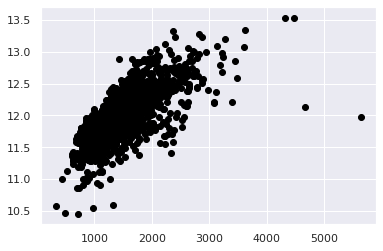

In [58]:
X1 = train
y1 = train['SalePrice']
plt.scatter(y =train.SalePrice,x = train.GrLivArea,c = 'black')
plt.show()

## Models

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import preprocessing

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('y_train: \n', y_train)
print('\n')
print('y_test: \n',y_test)

NameError: name 'X' is not defined

In [61]:
linr = LinearRegression()
linr.fit(X_train, y_train)

NameError: name 'X_train' is not defined

y = b0 + b1*x  --------------- linear regression model

y = b0 + b1*x + b2*x  -------  multiple linear regression model

In [62]:
inter = linr.intercept_
print('interception (b0):', inter)

AttributeError: 'LinearRegression' object has no attribute 'intercept_'

In [63]:
coeffs = linr.coef_
print('coeffs (b1,b2):\n', coeffs)

AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [64]:
y_pred = linr.predict(X_test)
print(y_pred)

NameError: name 'X_test' is not defined

In [65]:
import statsmodels.api as sm

In [66]:
X_1 = sm.add_constant(X_train)
ols_regr = sm.OLS(endog = y_train, exog = X_1).fit()

NameError: name 'X_train' is not defined

In [67]:
ols_regr.summary()

NameError: name 'ols_regr' is not defined

From our results, we see that

* The intercept β^0 = 5.99
* The R-squared value of 0.884 indicates 88%
* Adj. R-squared value 0.876 (good terms for model)
* low p-value in general (p-val <=0.05)

So, high R-square and low p-value means your model explains a lot of variation within the data and is significant

In [68]:
def adj_r2(r2score, train):
    adj_r2 = (1 - (1 - r2score) * ((train.shape[0] - 1) / 
          (train.shape[0] - train.shape[1] - 1)))
    return adj_r2

print('r2_score: ',r2_score(y_test, y_pred),
      '\nadj_r2: ',adj_r2(r2_score(y_test, y_pred), X_train),
      '\nmean_squared_error: ',mean_squared_error(y_test, y_pred),
      '\nrmse: ', np.sqrt(mean_squared_error(y_train, linr.predict(X_train))),)

NameError: name 'y_test' is not defined

RMSE (difference btw actual and predicted) close to zero. not bad

In [69]:
scorer = make_scorer(mean_squared_error,greater_is_better = False)
def rmse_CV_train(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model,X_train,y_train,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)
def rmse_CV_test(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model,X_test,y_test,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)

In [70]:
n_folds = 5

test_pre = linr.predict(X_test)
train_pre = linr.predict(X_train)
print('rmse on train',rmse_CV_train(linr).mean())
print('rmse on test',rmse_CV_test(linr).mean())

NameError: name 'X_test' is not defined

In [71]:
#plot between predicted values and residuals
plt.scatter(train_pre, train_pre - y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre,test_pre - y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

NameError: name 'train_pre' is not defined

In [72]:
# Plot predictions - Real values
plt.scatter(train_pre, y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

NameError: name 'train_pre' is not defined

In [73]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)

print("Ridge RMSE on Training set :", rmse_CV_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_CV_test(ridge).mean())

# Plot important coefficients
coef = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coef != 0)) + " features and eliminated the other " +  \
      str(sum(coef == 0)) + " features")
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

NameError: name 'RidgeCV' is not defined

In [74]:
data = pd.concat([train, test], sort=False)
data = data.reset_index(drop=True)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Id
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,None,0,2,2008,WD,Normal,12.247699,NaN
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,None,None,None,0,5,2007,WD,Normal,12.109016,NaN
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,None,None,None,0,9,2008,WD,Normal,12.317171,NaN
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,None,None,None,0,2,2006,WD,Abnorml,11.849405,NaN
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,None,None,None,0,12,2008,WD,Normal,12.429220,NaN


In [75]:
_list = []
for col in data.columns:
    if type(data[col][0]) == type('str'): 
        _list.append(col)

le = preprocessing.LabelEncoder()
for li in _list:
    le.fit(list(set(data[li])))
    data[li] = le.transform(data[li])

train_0, test_0 = data[:len(train)], data[len(train):]

X = train_0.drop(columns=['SalePrice', 'Id']) 
y = train_0['SalePrice']

test_0 = test_0.drop(columns=['SalePrice', 'Id'])

### Light GBM

###### LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

1. Faster training speed and higher efficiency.
2. Lower memory usage.
3. Better accuracy.
4. Support of parallel and GPU learning.
5. Capable of handling large-scale data.

In [76]:
kfold = KFold(n_splits=5, random_state = 2020, shuffle = True)

model_lgb = lgb.LGBMRegressor (objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(X, y)
print('LightGBM score: ', r2_score(model_lgb.predict(X), y))

LightGBM score:  0.9619023069528009


### XGBoost
###### XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks.It is a perfect combination of software and hardware optimization techniques to yield superior results using less computing resources in the shortest amount of time.

In [77]:
import xgboost as xgb

In [78]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_xgb.fit(X, y)
print('XGBoost score: ', r2_score(model_xgb.predict(X), y))

XGBoost score:  0.9576912592388165


### Catboost (firstly met in "How to win in Kaggle Comp.")
###### Catboost is a type of gradient boosting algorithms which can automatically deal with categorical variables without showing the type conversion error, which helps you to focus on tuning your model better rather than sorting out trivial errors.Make sure you handle missing data well before you proceed with the implementation.

In [79]:
from catboost import CatBoostRegressor

In [80]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
cb_model.fit(X, y)
print('CatBoost score: ', r2_score(cb_model.predict(X), y))

0:	learn: 0.3868843	total: 99.7ms	remaining: 49.7s
50:	learn: 0.1356728	total: 1.43s	remaining: 12.6s
100:	learn: 0.0925286	total: 2.76s	remaining: 10.9s
150:	learn: 0.0752312	total: 4.08s	remaining: 9.44s
200:	learn: 0.0622134	total: 5.42s	remaining: 8.06s
250:	learn: 0.0524159	total: 6.79s	remaining: 6.74s
300:	learn: 0.0444311	total: 8.11s	remaining: 5.36s
350:	learn: 0.0372472	total: 9.44s	remaining: 4s
400:	learn: 0.0318479	total: 10.7s	remaining: 2.65s
450:	learn: 0.0273689	total: 12s	remaining: 1.3s
499:	learn: 0.0231756	total: 13.3s	remaining: 0us
CatBoost score:  0.996555366288359


# My first Neural Network

In [81]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,10,3,65.0,8450,1,1,3,3,0,4,...,0,0,3,4,1,0,4,2,8,4
1,5,3,80.0,9600,1,1,3,3,0,2,...,0,0,3,4,1,0,7,1,8,4
2,10,3,68.0,11250,1,1,0,3,0,4,...,0,0,3,4,1,0,11,2,8,4
3,11,3,60.0,9550,1,1,0,3,0,0,...,0,0,3,4,1,0,4,0,8,0
4,10,3,84.0,14260,1,1,0,3,0,2,...,0,0,3,4,1,0,3,2,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,10,3,62.0,7917,1,1,3,3,0,4,...,0,0,3,4,1,0,10,1,8,4
1456,5,3,85.0,13175,1,1,3,3,0,4,...,0,0,3,2,1,0,4,4,8,4
1457,11,3,66.0,9042,1,1,3,3,0,4,...,0,0,3,0,3,2500,7,4,8,4
1458,5,3,68.0,9717,1,1,3,3,0,4,...,0,0,3,4,1,0,6,4,8,4


In [82]:
#val_and_test size is 30%
x_train, x_val_and_test, Y_train, Y_val_and_test = train_test_split(X, y, test_size=0.3)

In [83]:
x_val, x_test, Y_val, Y_test = train_test_split(x_val_and_test, Y_val_and_test, test_size=0.5)

* x_train (10 input features, 70% of full dataset)
* x_val (10 input features, 15% of full dataset)
* x_test (10 input features, 15% of full dataset)
* Y_train (1 label, 70% of full dataset)
* Y_val (1 label, 15% of full dataset)
* Y_test (1 label, 15% of full dataset)

In [84]:
print('x_train: ', x_train.shape)
print('x_val:   ', x_val.shape)
print('x_test:  ', x_test.shape)
print('Y_train: ', Y_train.shape)
print('Y_val:   ', Y_val.shape)
print('Y_test:  ', Y_test.shape)

x_train:  (1022, 79)
x_val:    (219, 79)
x_test:   (219, 79)
Y_train:  (1022,)
Y_val:    (219,)
Y_test:   (219,)


### First Step: Setting up the Architecture
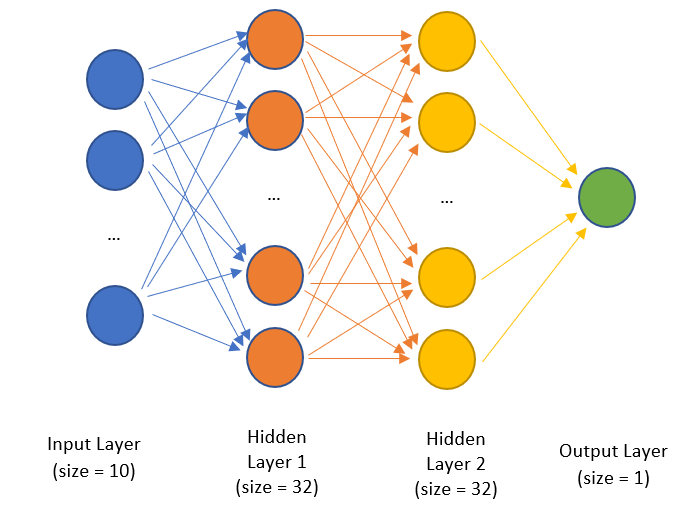

In [85]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [86]:
#specify in Keras sequential model
modell = Sequential([
    Dense(9, activation='relu', input_shape=(79,)),
    Dense(9, activation='relu'),
    Dense(1, activation='sigmoid'),
])

This says that we will we’ll describe it sequentially (layer by layer).
1. Dense(9, activation='relu', input_shape=(79,))
    * First layer as a dense layer with 9 neurons
    * ReLU activation
    * input shape (input features)


2. Dense(9, activation='relu')
    * Second layer is also with 9 neurons
    * ReLU activation
    
    
3. Dense(1, activation='sigmoid')
    * Third layer is a dense layer with 1 neuron
    * Sigmoid activation

### Second Step: Filling in the best numbers

In [87]:
modell.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

1. optimizer='sgd'
    * ‘sgd’ refers to stochastic gradient descent (over here, it refers to mini-batch gradient descent), which we’ve seen in Intuitive Deep Learning Part 1b.


2. loss='binary_crossentropy'
    * The loss function for outputs that take the values 1 or 0 is called binary cross entropy.


3. metrics=['accuracy']
    * Lastly, we want to track accuracy on top of the loss function.

In [88]:
hist = modell.fit(x_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(x_val, Y_val))

Train on 1022 samples, validate on 219 samples
Epoch 1/100
1022/1022 [==============================] - 0s 274us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/100
1022/1022 [==============================] - 0s 39us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/100
1022/1022 [==============================] - 0s 39us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/100
1022/1022 [==============================] - 0s 40us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/100
1022/1022 [==============================] - 0s 39us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/100
1022/1022 [==============================] - 0s 41us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/100
1022/1022 [==============================] - 0s 42us

In [89]:
modell.evaluate(x_test, Y_test)[1]

219/219 [==============================] - 0s 30us/step


0.0

# Okay, I got nothing, cool

### MLP Regressor (Neural Networks)
###### Neural Networks are a machine learning algorithm that involves fitting many hidden layers used to represent neurons that are connected with synaptic activation functions. These essentially use a very simplified model of the brain to model and predict data.

In [90]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [91]:
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
mlp_predict = mlp.predict(X_test)

NameError: name 'X_train' is not defined

In [92]:
print('MLPRegressor score: ', r2_score(mlp.predict(X), y))

NotFittedError: This MLPRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [93]:
search_random = {'n_estimators': range(1000, 5000, 100), 'learning_rate':[0.01, 0.1, 0.05]}
abc = GradientBoostingRegressor()
abc.fit(X_train, y_train)
abc_predict = abc.predict(X_test)

NameError: name 'X_train' is not defined

In [94]:
print('GradientBoostingRegressor: ',r2_score(abc.predict(X), y))

NotFittedError: This GradientBoostingRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [95]:
from sklearn.ensemble import RandomForestRegressor

In [96]:
from vecstack import stacking

In [97]:
models = [MLPRegressor(), 
          GradientBoostingRegressor(), 
          CatBoostRegressor(),
          lgb.LGBMRegressor(), 
          xgb.XGBRegressor()]
      
S_Train, S_Test = stacking(models, X_train, y_train, X_test, regression=True, verbose=2)
model = RandomForestRegressor()  
model = model.fit(S_Train, y_train)
model_pred = model.predict(S_Test)

NameError: name 'X_train' is not defined

In [98]:
print('Stacking: ', r2_score(model_pred,y_pred))

NameError: name 'model_pred' is not defined

### Submission
I still don't know how to do it correct.

In [99]:
print('LRegression score:  ', r2_score(y_test, y_pred))
print('LightGBM score:     ', r2_score(model_lgb.predict(X), y))
print('XGBoost score:      ', r2_score(model_xgb.predict(X), y))
print('CatBoost score:     ', r2_score(cb_model.predict(X), y))
print('MLPRegressor score: ', r2_score(mlp.predict(X), y))
print('GradientBoostinReg: ', r2_score(abc.predict(X), y))
print('Stacking:           ', r2_score(model_pred,y_pred))

NameError: name 'y_test' is not defined

In [100]:
q1 = submission['SalePrice'].quantile(0.045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission_1.csv", index=False)